<a href="https://colab.research.google.com/github/Shreyas911/PINN/blob/main/PINN_heat_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics Informed Neural Networks for the Heat Equation

## Install the required libraries

We first import all the required libraries. In order to use PyTorch with TPUs, we have to install the TPU client using pip.

In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl

### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_xla ## Specially for TPUs
import torch_xla.core.xla_model as xm ## Specially for TPUs

     |████████████████████████████████| 144.6MB 89kB/s 
     |████████████████████████████████| 61kB 3.4MB/s 
ERROR: earthengine-api 0.1.260 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


## Specify the device

We now specify the device type. There are two options to leverge the power of parallel computing. We can either use GPUs or TPUs.

In [ ]:
### GPU ###
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#torch.cuda.empty_cache()
###########

### TPU ###
device = xm.xla_device()
###########

device

device(type='xla', index=1)

We now define a class of neural networks which inherits from the *nn.Module* class. It's a 5 layer Artificial Neural Network (ANN). We make use of the tanh activation function. This allows the model to learn highly non-linear relations.

In [ ]:
class physics_informed_NN(nn.Module):
    
    def __init__ (self):

        super(physics_informed_NN, self).__init__()

        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

physics_informed_NN

__main__.physics_informed_NN

##True solution 

We now generate the true solution to the heat equation and then look to make our neural network model *emulate* this PDE - 

$$\frac{\partial u(x,t)}{\partial t} = D \frac{\partial^2 u(x,t)}{\partial x^2}\\
u(0,t) = 0, u(1,t) = 0 \:\:\:\forall t \in [0,10]\\ 
u(x,0) = \sin(x) \:\:\:\forall x \in [0,1]\\ 
D = 0.02
$$

The true solution will be generated using $2^{\text{nd}}$ order finite difference methods on a very fine uniform, grid.



In [ ]:
def true_solution(L, T, dx, dt, D):

    ### Grids for x and t
    x = np.arange(0, L+dx, dx)
    t = np.arange(0, T+dt, dt)
    u = np.zeros((len(x), len(t)))
    u[:,0] = np.sin(x*np.pi/L)
    u[-1,0] = 0.
    nx = len(x) - 1
    nt = len(t) - 1

    for j in range(nt):
        for i in range(1, nx):
            u[i, j+1] = u[i, j] + D * dt/dx**2 * (u[i+1, j] - 2*u[i, j] + u[i-1, j])

    return x, t, u


Here is the contourf plot for the true solution.

(101,) (100001,)


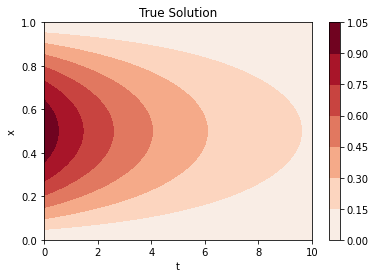

In [ ]:
import matplotlib.colors as mcolors

L = 1.
D = 0.02
T = 10.
dx = 0.01
dt = 0.0001
x, t, u_true = true_solution(L, T, dx, dt, D)
print(x.shape, t.shape)
norm = mcolors.TwoSlopeNorm(vmin=-1, vmax = u_true.max(), vcenter=0)
plt.contourf(t,x,u_true, cmap = 'RdBu_r', norm = norm)
plt.xlabel('t')
plt.ylabel('x')
plt.title('True Solution')
plt.colorbar()

## How do we actually train our network?

Since we are training our network to emulate the PDE, we want to penalize the physics not being followed. We define the Loss function as follows (superscripts indicate the data) - 


$$\text{PDE operator} \quad \mathcal{F}(x, t) = u_t (x,t) - D u_{xx} (x,t) $$
$$\text{Loss function} \quad \mathcal{L} = \frac{1}{N_i}\sum_{i=1}^{N_i} \left(u^i - u(x^i,0)\right)^2 + \frac{1}{N_b}\sum_{i=1}^{N_b} \left(u^i - u(x^i, t^i)\right)^2 + 100 \frac{1}{N_c}\sum_{i=1}^{N_c} \left(\mathcal{F}(x^i, t^i) \right)^2$$

where, $N_i$, $N_b$, $N_c$ are the initial value points, boundary value points and collocation points in the interior where we want the model to obey the physics.

We only need to randomly sample the domain and boundaries to feed these points to the neural network. We will use $N_i = 50, N_b = 100, N_c = 20,000$ points to train the neural network, which is pretty sparse. The snippet below is to prepare the datasets.

In [ ]:
x = x.reshape(-1,1)
t = t.reshape(-1,1)

### Initial data
Ni = 50
random_i = np.random.permutation(x.shape[0])[:Ni]
x_i = x[random_i]
t_i = np.zeros((Ni, 1))
u_i = np.reshape(u_true[random_i, 0], (-1,1))

### Boundary data
Nb = 100
Nb = int(Nb/2) # Split points to two boundaries

random_b = np.random.permutation(t.shape[0])[:Nb]
x_l = np.zeros((Nb, 1))
x_r = L*np.ones((Nb, 1))
t_b = t[random_b]
u_l = np.reshape(u_true[0, random_b], (-1,1))
u_r = np.reshape(u_true[-1, random_b], (-1,1))

### Collocation points - sample such that you don't sample the boundary and initial points again
Nc = 20000

x_grid = np.tile(x,(1, t.shape[0]))
t_grid = np.tile(t.T,(x.shape[0], 1))

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nc] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_c = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_c[1:-1,1:] = temp
x_c = x_grid[random_c].reshape(-1,1)
t_c = t_grid[random_c].reshape(-1,1)
u_c = u_true[random_c].reshape(-1,1)

We plot the points we have sampled.

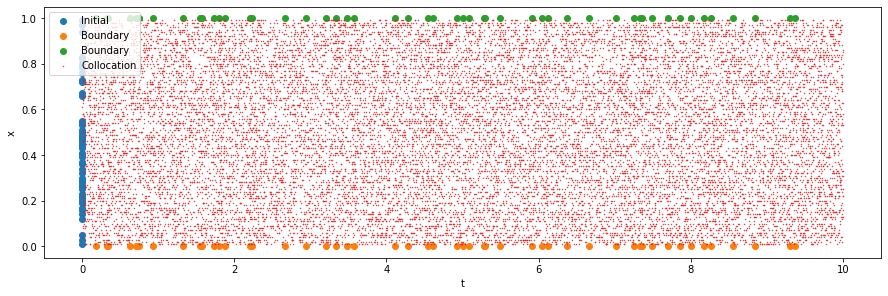

In [ ]:
plt.figure(figsize = (15,15))
plt.gca().set_aspect(3)
plt.scatter(t_i, x_i, label = "Initial")
plt.scatter(t_b, x_l, label = "Boundary")
plt.scatter(t_b, x_r, label = "Boundary")
plt.scatter(t_c, x_c, label = "Collocation", s = 0.2)
plt.xlabel('t')
plt.ylabel('x')
plt.legend()

We have our data and we now convert it to torch tensors and concatenate the respective $x,t$ tensors to feed to the neural network.

In [ ]:
x_torch_i = torch.from_numpy(x_i).float()
t_torch_i = torch.from_numpy(t_i).float()
u_torch_i = torch.from_numpy(u_i).float()

x_torch_l = torch.from_numpy(x_l).float()
x_torch_r = torch.from_numpy(x_r).float()
t_torch_b = torch.from_numpy(t_b).float()
u_torch_l = torch.from_numpy(u_l).float()
u_torch_r = torch.from_numpy(u_r).float()

x_torch_c = torch.from_numpy(x_c).float()
t_torch_c = torch.from_numpy(t_c).float()
u_torch_c = torch.from_numpy(u_c).float()

### Concatenate the respective x and t tensors 
X_i = torch.cat((x_torch_i, t_torch_i), 1)

X_l = torch.cat((x_torch_l, t_torch_b), 1)
X_r = torch.cat((x_torch_r, t_torch_b), 1)

X_c = torch.cat((x_torch_c, t_torch_c), 1)

Now we transfer this data, as well as an object of the *physics_informed_NN* class to the TPUs to run our computatations.

In [ ]:
from torchsummary import summary

PINN = physics_informed_NN()
PINN.to(device)

X_i = X_i.to(device)
U_i = u_torch_i.to(device)

X_l = X_l.to(device)
U_l = u_torch_l.to(device)
X_r = X_r.to(device)
U_r = u_torch_r.to(device)

X_c = X_c.to(device)
U_c = u_torch_c.to(device)

Using the loss function defined above, we run backpropagation on the neural network using the *Adam* optimizer. Our criterion is obviously MSE Loss and we also have a scheduler to control the learning rate.

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.001)
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)

The loop below is actually training the network. The epochs just mean the number of times the whole dataset is exposed to the neural network. Note that running on TPUs requires slightly different commands for optimizer steps.

In [ ]:
statistics = []
for epochs in range(5000):

    X_c_clone = X_c.clone()
    X_c_clone.requires_grad = True
    u_pred = PINN(X_c_clone)
    gradients = torch.autograd.grad(torch.sum(u_pred), X_c_clone, create_graph=True)
    u_x = gradients[0][:,0]
    u_t = gradients[0][:,1]

    hessians = torch.autograd.grad(torch.sum(u_x), X_c_clone, create_graph=True)
    u_xx = hessians[0][:,0]

    collocation_mse = criterion(D*u_xx, u_t)
    initial_mse = criterion(PINN(X_i), U_i)
    left_mse = criterion(PINN(X_l), U_l)
    right_mse = criterion(PINN(X_r), U_r)

    loss = right_mse + left_mse + initial_mse + 100*collocation_mse

    optimizer.zero_grad()  
    loss.backward()       
    xm.optimizer_step(optimizer)
    xm.mark_step()
    my_lr_scheduler.step()

    if (epochs % 100 == 0):
        statistics.append([epochs, loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy()])
        print (f'epoch = {epochs}, loss = {loss}, left_loss = {left_mse}, right_loss = {right_mse}, initial_mse = {initial_mse}, collocation_mse = {collocation_mse}')

epoch = 0, loss = 0.5826491713523865, left_loss = 0.0007688676123507321, right_loss = 1.7287045920966193e-05, initial_mse = 0.5788853764533997, collocation_mse = 2.9776147130178288e-05
epoch = 100, loss = 0.0840686708688736, left_loss = 0.012627998366951942, right_loss = 0.01211455650627613, initial_mse = 0.036856330931186676, collocation_mse = 0.00022469786927103996
epoch = 200, loss = 0.008393638767302036, left_loss = 0.0005930351908318698, right_loss = 0.0017599635757505894, initial_mse = 0.0011995447566732764, collocation_mse = 4.841095505980775e-05
epoch = 300, loss = 0.008432846516370773, left_loss = 0.0012360932305455208, right_loss = 0.0012490823864936829, initial_mse = 0.00028085196390748024, collocation_mse = 5.666818469762802e-05
epoch = 400, loss = 0.0012833739165216684, left_loss = 8.78536666277796e-05, right_loss = 8.925396832637489e-05, initial_mse = 0.00010417466546641663, collocation_mse = 1.0020916306530125e-05
epoch = 500, loss = 0.0011596617987379432, left_loss = 0.

We now check the performance of our model on the entire grid.

In [ ]:
## Grid x,t together for test dataa
test_data = np.array(np.meshgrid(x, t))
test_data = np.moveaxis(test_data, [0, 1, 2], [-1,0,1])
input_test_data = torch.from_numpy(np.reshape(test_data, (-1, 2)))
input_test_data = input_test_data.to(device).float()

### Actual solution on the entire grid
u_test_data = torch.from_numpy(np.reshape(u_true, (-1,1)))

### Predict on the entire grid
with torch.no_grad():
##### FOR TPUs ######
    u_predicted = PINN(input_test_data).cpu().data.numpy()

##### FOR CUDA/GPUs ######
#   if torch.cuda.is_available():
#     h_predicted = PINN(input_test_data).cpu().data.numpy()
#   else:
#     h_predicted = PINN(input_test_data).data.numpy()


Now, we plot our predicted solution. Since *u_predicted* is a single vector, we need to reshape it into the shape of the grid in order to plot the filled contours. 

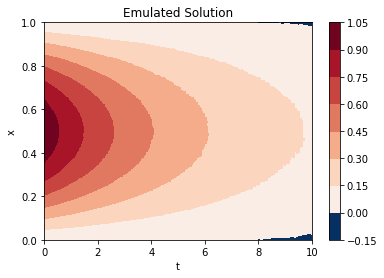

In [ ]:
norm = mcolors.TwoSlopeNorm(vmin=u_predicted.min(), vmax = u_predicted.max(), vcenter=0)
u_pred_final = np.reshape(u_predicted, (u_true.shape[1], u_true.shape[0])).T

plt.contourf(np.squeeze(t),np.squeeze(x),u_pred_final, cmap = 'RdBu_r', norm = norm)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated Solution')
plt.colorbar()
plt.show()

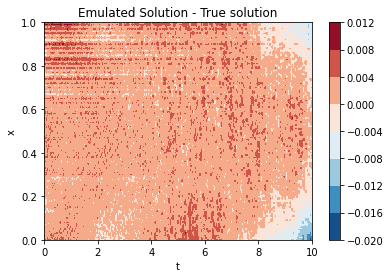

In [ ]:
plt.contourf(np.squeeze(t),np.squeeze(x),u_pred_final-u_true, cmap = 'RdBu_r')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated Solution - True solution')
plt.colorbar()
plt.show()

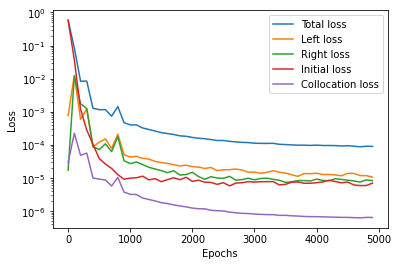

In [ ]:
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[1] for statistic in statistics], label = 'Total loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[2] for statistic in statistics], label = 'Left loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[3] for statistic in statistics], label = 'Right loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[4] for statistic in statistics], label = 'Initial loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[5] for statistic in statistics], label = 'Collocation loss')
plt.legend()

## Inferring diffusion coefficient from data

Since we are training our network to find the diffusion coefficient, we want to enforce the physics, as well look to fit the data. We define the Loss function as follows (superscripts indicate the data) - 


$$\text{PDE operator} \quad \mathcal{F}(x, t) = u_t (x,t) - D u_{xx} (x,t) $$
$$\text{Loss function} \quad \mathcal{L} = \frac{1}{N_i}\sum_{i=1}^{N_i} \left(u^i - u(x^i,0)\right)^2 + \frac{1}{N_b}\sum_{i=1}^{N_b} \left(u^i - u(x^i, t^i)\right)^2 + 75\frac{1}{N_c}\sum_{i=1}^{N_c} \left(\mathcal{F}(x^i, t^i) \right)^2 + 25\frac{1}{N_d}\sum_{i=1}^{N_d} \left(u^i - u(x^i, t^i)\right)^2 $$

where, $N_i$, $N_b$, $N_c$ are the initial value points, boundary value points and collocation points in the interior where we want the model to obey the physics.

Here, we optimize wrt both the neural network parameters as well as the unknown diffusion coefficient $D$.

In [ ]:
x = x.reshape(-1,1)
t = t.reshape(-1,1)

### Initial data
Ni = 50
random_i = np.random.permutation(x.shape[0])[:Ni]
x_i = x[random_i]
t_i = np.zeros((Ni, 1))
u_i = np.reshape(u_true[random_i, 0], (-1,1))

### Boundary data
Nb = 100
Nb = int(Nb/2) # Split points to two boundaries

random_b = np.random.permutation(t.shape[0])[:Nb]
x_l = np.zeros((Nb, 1))
x_r = L*np.ones((Nb, 1))
t_b = t[random_b]
u_l = np.reshape(u_true[0, random_b], (-1,1))
u_r = np.reshape(u_true[-1, random_b], (-1,1))

### Collocation points - sample such that you don't sample the boundary and initial points again
Nc = 20000

x_grid = np.tile(x,(1, t.shape[0]))
t_grid = np.tile(t.T,(x.shape[0], 1))

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nc] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_c = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_c[1:-1,1:] = temp
x_c = x_grid[random_c].reshape(-1,1)
t_c = t_grid[random_c].reshape(-1,1)
u_c = u_true[random_c].reshape(-1,1)

### Data points - sample such that you don't sample the boundary and initial points again
Nd = 20000

temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
temp[:Nd] = 1
temp = np.random.permutation(temp)
temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
random_d = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
random_d[1:-1,1:] = temp
x_d = x_grid[random_d].reshape(-1,1)
t_d = t_grid[random_d].reshape(-1,1)
u_d = u_true[random_d].reshape(-1,1)

We plot the points we have sampled.

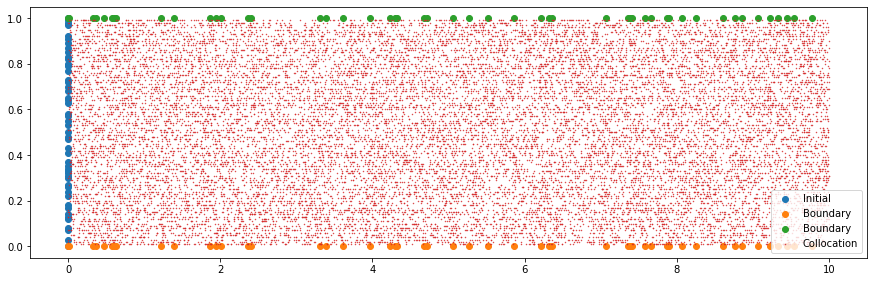

In [ ]:
plt.figure(figsize = (15,15))
plt.gca().set_aspect(3)
plt.scatter(t_i, x_i, label = "Initial")
plt.scatter(t_b, x_l, label = "Boundary")
plt.scatter(t_b, x_r, label = "Boundary")
plt.scatter(t_c, x_c, label = "Collocation", s = 0.2)
plt.legend()

We have our data and we now convert it to torch tensors and concatenate the respective $x,t$ tensors to feed to the neural network.

In [ ]:
x_torch_i = torch.from_numpy(x_i).float()
t_torch_i = torch.from_numpy(t_i).float()
u_torch_i = torch.from_numpy(u_i).float()

x_torch_l = torch.from_numpy(x_l).float()
x_torch_r = torch.from_numpy(x_r).float()
t_torch_b = torch.from_numpy(t_b).float()
u_torch_l = torch.from_numpy(u_l).float()
u_torch_r = torch.from_numpy(u_r).float()

x_torch_c = torch.from_numpy(x_c).float()
t_torch_c = torch.from_numpy(t_c).float()
u_torch_c = torch.from_numpy(u_c).float()

x_torch_d = torch.from_numpy(x_d).float()
t_torch_d = torch.from_numpy(t_d).float()
u_torch_d = torch.from_numpy(u_d).float()

### Concatenate the respective x and t tensors 
X_i = torch.cat((x_torch_i, t_torch_i), 1)

X_l = torch.cat((x_torch_l, t_torch_b), 1)
X_r = torch.cat((x_torch_r, t_torch_b), 1)

X_c = torch.cat((x_torch_c, t_torch_c), 1)

X_d = torch.cat((x_torch_d, t_torch_d), 1)

Now we transfer this data, as well as an object of the *physics_informed_NN* class to the TPUs to run our computatations.

In [ ]:
PINN = physics_informed_NN()
PINN.to(device)

X_i = X_i.to(device)
U_i = u_torch_i.to(device)

X_l = X_l.to(device)
U_l = u_torch_l.to(device)
X_r = X_r.to(device)
U_r = u_torch_r.to(device)

X_c = X_c.to(device)
U_c = u_torch_c.to(device)

X_d = X_d.to(device)
U_d = u_torch_d.to(device)

Using the loss function defined above, we run backpropagation on the neural network using the *Adam* optimizer. Our criterion is obviously MSE Loss and we also have a scheduler to control the learning rate.

In [ ]:
optimizer = torch.optim.Adam(PINN.parameters(), lr=0.001)
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.9)
D = torch.tensor(0., requires_grad = True)
optimizer.add_param_group({'params': D})

The loop below is actually training the network. The epochs just mean the number of times the whole dataset is exposed to the neural network. Note that running on TPUs requires slightly different commands for optimizer steps.

In [ ]:
statistics = []
for epochs in range(5000):

    X_c_clone = X_c.clone()
    X_c_clone.requires_grad = True
    u_pred = PINN(X_c_clone)
    gradients = torch.autograd.grad(torch.sum(u_pred), X_c_clone, create_graph=True)
    u_x = gradients[0][:,0]
    u_t = gradients[0][:,1]

    hessians = torch.autograd.grad(torch.sum(u_x), X_c_clone, create_graph=True)
    u_xx = hessians[0][:,0]

    collocation_mse = criterion(D*u_xx, u_t)
    initial_mse = criterion(PINN(X_i), U_i)
    left_mse = criterion(PINN(X_l), U_l)
    right_mse = criterion(PINN(X_r), U_r)
    data_mse = criterion(PINN(X_d), U_d)

    loss = right_mse + left_mse + initial_mse + 75*collocation_mse + 25*data_mse

    optimizer.zero_grad()  
    loss.backward()       
    xm.optimizer_step(optimizer)
    xm.mark_step()
    my_lr_scheduler.step()

    if (epochs % 100 == 0):
        statistics.append([epochs, D.detach().clone().cpu().data.numpy(), loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy(), data_mse.cpu().data.numpy()])
        print (f'epoch = {epochs}, D = {D}, loss = {loss}, l_loss = {left_mse}, r_loss = {right_mse}, i_mse = {initial_mse}, c_mse = {collocation_mse}, d_mse = {data_mse}')

epoch = 0, D = -0.0009999938774853945, loss = 4.643564224243164, l_loss = 0.0035960294771939516, r_loss = 0.0030679991468787193, i_mse = 0.5554278492927551, c_mse = 2.524398223613389e-05, d_mse = 0.16318315267562866
epoch = 100, D = 0.10116731375455856, loss = 0.9166803359985352, l_loss = 0.08328255265951157, r_loss = 0.08175309747457504, i_mse = 0.10579586774110794, c_mse = 0.000907433801330626, d_mse = 0.023111650720238686
epoch = 200, D = 0.04386606439948082, loss = 0.5457760691642761, l_loss = 0.027353936806321144, r_loss = 0.029108885675668716, i_mse = 0.05350000411272049, c_mse = 0.00039480553823523223, d_mse = 0.01624811254441738
epoch = 300, D = 0.01743145100772381, loss = 0.0804133415222168, l_loss = 0.001760989660397172, r_loss = 0.004323398694396019, i_mse = 0.011753018945455551, c_mse = 0.0005246478249318898, d_mse = 0.0009290939196944237
epoch = 400, D = 0.017042573541402817, loss = 0.045017994940280914, l_loss = 0.0004965024418197572, r_loss = 0.0015673766611143947, i_mse

We now check the performance of our model on the entire grid.

In [ ]:
## Grid x,t together for test dataa
test_data = np.array(np.meshgrid(x, t))
test_data = np.moveaxis(test_data, [0, 1, 2], [-1,0,1])
input_test_data = torch.from_numpy(np.reshape(test_data, (-1, 2)))
input_test_data = input_test_data.to(device).float()

### Actual solution on the entire grid
u_test_data = torch.from_numpy(np.reshape(u_true, (-1,1)))

### Predict on the entire grid
with torch.no_grad():
##### FOR TPUs ######
    u_predicted = PINN(input_test_data).cpu().data.numpy()

##### FOR CUDA/GPUs ######
#   if torch.cuda.is_available():
#     h_predicted = PINN(input_test_data).cpu().data.numpy()
#   else:
#     h_predicted = PINN(input_test_data).data.numpy()


Now, we plot our predicted solution. Since *u_predicted* is a single vector, we need to reshaoe it into the shape of the grid in order to plot the filled contours. 

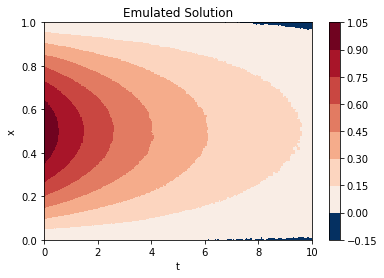

In [ ]:
norm = mcolors.TwoSlopeNorm(vmin=u_predicted.min(), vmax = u_predicted.max(), vcenter=0)
u_pred_final = np.reshape(u_predicted, (u_true.shape[1], u_true.shape[0])).T

plt.contourf(np.squeeze(t),np.squeeze(x),u_pred_final, cmap = 'RdBu_r', norm = norm)
plt.xlabel('t')
plt.ylabel('x')
plt.title('Emulated Solution')
plt.colorbar()
plt.show()

tensor(0.0200, requires_grad=True)
[array(-0.00099999, dtype=float32), array(0.10116731, dtype=float32), array(0.04386606, dtype=float32), array(0.01743145, dtype=float32), array(0.01704257, dtype=float32), array(0.01776866, dtype=float32), array(0.01832856, dtype=float32), array(0.0186907, dtype=float32), array(0.01888161, dtype=float32), array(0.01904193, dtype=float32), array(0.0192139, dtype=float32), array(0.01934366, dtype=float32), array(0.01945141, dtype=float32), array(0.01955032, dtype=float32), array(0.01964941, dtype=float32), array(0.01971471, dtype=float32), array(0.01974619, dtype=float32), array(0.01981034, dtype=float32), array(0.01984639, dtype=float32), array(0.01985794, dtype=float32), array(0.01988449, dtype=float32), array(0.01989997, dtype=float32), array(0.01991514, dtype=float32), array(0.01992532, dtype=float32), array(0.01992966, dtype=float32), array(0.01994022, dtype=float32), array(0.01995388, dtype=float32), array(0.01994455, dtype=float32), array(0.01995

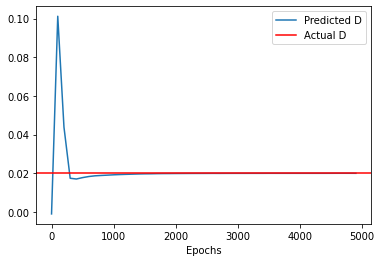

In [ ]:
print(D)
plt.plot([statistic[0] for statistic in statistics], [statistic[1] for statistic in statistics], label = 'Predicted D')
plt.axhline(0.02, label = 'Actual D', color = 'red')
plt.legend()
plt.xlabel('Epochs')
print([statistic[1] for statistic in statistics])

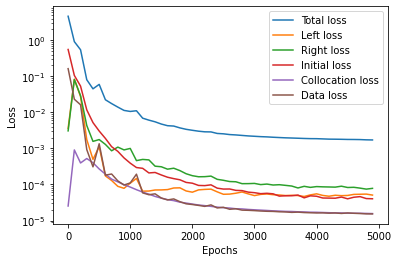

In [ ]:
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[2] for statistic in statistics], label = 'Total loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[3] for statistic in statistics], label = 'Left loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[4] for statistic in statistics], label = 'Right loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[5] for statistic in statistics], label = 'Initial loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[6] for statistic in statistics], label = 'Collocation loss')
plt.plot([statistic[0] for statistic in statistics], [statistic[7] for statistic in statistics], label = 'Data loss')
plt.legend()